In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats

In [2]:
fileName = 'orders-20220609-114922.csv'
df = pd.read_csv(fileName, low_memory = False)
df = df[['TransactTime', 'OrderID', 'Price', 'Symbol.1', 'Group']]
df['TransactTime'] = pd.to_datetime(df['TransactTime'])
df = df.sort_values(by='TransactTime').dropna()
splits = df['Group'].str.split('/', 2, expand = True)
df['Group'] = splits[0]
df['Parent'] = splits[1]
df = df.loc[df['Symbol.1'] == 'BTC']
df['Price'] = pd.to_numeric(df['Price'])

In [3]:
chainDfDict = {}

for _, row in df.iterrows():
    parent = row.Parent
    
    if parent in chainDfDict.keys():
        chainDfDict[parent] = pd.concat([chainDfDict[parent], pd.DataFrame({'Time' : [row.TransactTime], 'Price' : [row.Price]})])
    else:
        chainDfDict[parent] = pd.DataFrame({'Time' : [row.TransactTime], 'Price' : [row.Price]})

In [4]:
for _, row in df.iterrows():
    order = row.OrderID
    
    if order in chainDfDict.keys():
        chainDfDict[parent] = pd.concat([chainDfDict[parent], pd.DataFrame({'Time' : [row.TransactTime], 'Price' : [row.Price]})]).drop_duplicates()

In [5]:
secInYear = 60*60*24*365

volCalc = pd.DataFrame({'logReturns' : [], 'tDelta' : []})

for chainKey in chainDfDict.keys():
    chain = chainDfDict[chainKey]
    chain = chain.sort_values(by='Time')
    chain['tDelta'] = (chain['Time']-chain['Time'].shift(1)).dt.seconds/secInYear
    chain['logReturns'] = np.log(chain['Price']) - np.log(chain['Price'].shift(1))
    chain = chain[['logReturns', 'tDelta']].dropna()
    volCalc = pd.concat([volCalc, chain])

In [7]:
volCalc['range'] = volCalc['logReturns']/np.sqrt(volCalc['tDelta'])

In [8]:
volCalc.replace([np.inf, -np.inf], np.nan, inplace=True)
volCalc = volCalc.dropna()
volCalc = volCalc[(np.abs(stats.zscore(volCalc)) < 3).all(axis=1)]

In [178]:
volCalc.range.std()/np.sqrt(365/np.sqrt(volCalc.tDelta).sum())

0.31560602624119455

<AxesSubplot:>

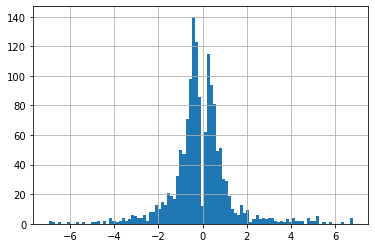

In [10]:
volCalc['range'].hist(bins=100)